In [ ]:
import cv2
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import os

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

from random import randint
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras import layers
from tensorflow.keras import Model, Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator


print(tf.__version__)


2.12.0


In [ ]:
img_width, img_height = 224,224

train_data_dir = '/drive/My Drive/trainf/'
validation_data_dir = '/drive/My Drive/validf'
test_data_dir = '/drive/My Drive/testf/'

nb_train_samples = 1601
nb_validation_samples = 804
epochs = 12
batch_size = 50

In [ ]:
CLASSES = {'ERPR': 0, 'HER': 1 , 'Luminal':2 , 'Triple':3}

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.3,
    zoom_range = 0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
from google.colab import drive
drive.mount('/drive', force_remount=True)

Mounted at /drive


In [ ]:
train_batches = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical')

Found 1601 images belonging to 4 classes.


In [ ]:
valid_batches = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical')

Found 404 images belonging to 4 classes.


In [ ]:
test_batches = test_datagen.flow_from_directory(
    test_data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical')

Found 804 images belonging to 4 classes.


In [ ]:
import pandas as pd
import numpy as np
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import math
import datetime

In [ ]:
vgg16 = applications.VGG16(include_top=False, weights='imagenet')

In [ ]:
predict_size_train = int(math.ceil(nb_train_samples / batch_size))

bottleneck_features_train = vgg16.predict_generator(train_batches, predict_size_train)

<ipython-input-11-fadb67f92965>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  bottleneck_features_train = vgg16.predict_generator(train_batches, predict_size_train)


In [ ]:
np.save('bottleneck_features_train.npy', bottleneck_features_train)

In [ ]:
generator_top = train_datagen.flow_from_directory(
   train_data_dir,
   target_size=(img_width, img_height),
   batch_size=batch_size,
   class_mode='categorical',
   shuffle=False)

nb_train_samples = len(generator_top.filenames)
num_classes = len(generator_top.class_indices)

# load the bottleneck features saved earlier
train_data = np.load('bottleneck_features_train.npy')

# get the class labels for the training data, in the original order
train_labels = generator_top.classes

# convert the training labels to categorical vectors
train_labels = to_categorical(train_labels, num_classes=num_classes)

Found 1601 images belonging to 4 classes.


In [ ]:
predict_size_train = int(math.ceil(nb_validation_samples / batch_size))

bottleneck_features_train = vgg16.predict_generator(valid_batches, predict_size_train)
np.save('bottleneck_features_valid.npy', bottleneck_features_train)

<ipython-input-14-40cf9d13c40f>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  bottleneck_features_train = vgg16.predict_generator(valid_batches, predict_size_train)


In [ ]:
generator_top1 = test_datagen.flow_from_directory(
   validation_data_dir,
   target_size=(img_width, img_height),
   batch_size=batch_size,
   class_mode='categorical',
   shuffle=False)

nb_validation_samples = len(generator_top1.filenames)
num_classes = len(generator_top1.class_indices)

# load the bottleneck features saved earlier
validation_data = np.load('bottleneck_features_valid.npy')

# get the class labels for the training data, in the original order
valid_labels = generator_top1.classes

# convert the training labels to categorical vectors
valid_labels = to_categorical(valid_labels, num_classes=num_classes)

Found 404 images belonging to 4 classes.


In [ ]:
#This is the best model we found. For additional models, check out I_notebook.ipynb
start = datetime.datetime.now()
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3)))
model.add(Dropout(0.8))
model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy',
   optimizer=optimizers.RMSprop(lr=1e-4),
   metrics=['acc'])
history = model.fit(train_data, train_labels,epochs=50,batch_size=batch_size,validation_data=(validation_data, valid_labels))
#model.save_weights(top_model_weights_path)
(eval_loss, eval_accuracy) = model.evaluate(validation_data, valid_labels, batch_size=batch_size,verbose=1)
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
print("[INFO] Loss: {}".format(eval_loss))
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/50
33/33 [==============================] - 3s 67ms/step - loss: 1.8491 - acc: 0.2367 - val_loss: 1.5031 - val_acc: 0.2500
Epoch 2/50
33/33 [==============================] - 2s 60ms/step - loss: 1.6660 - acc: 0.2511 - val_loss: 1.5363 - val_acc: 0.2475
Epoch 3/50
33/33 [==============================] - 1s 37ms/step - loss: 1.6577 - acc: 0.2761 - val_loss: 1.4216 - val_acc: 0.2673
Epoch 4/50
33/33 [==============================] - 1s 37ms/step - loss: 1.6050 - acc: 0.2911 - val_loss: 1.4088 - val_acc: 0.2500
Epoch 5/50
33/33 [==============================] - 1s 37ms/step - loss: 1.5780 - acc: 0.2792 - val_loss: 1.4983 - val_acc: 0.2426
Epoch 6/50
33/33 [==============================] - 1s 38ms/step - loss: 1.5765 - acc: 0.2911 - val_loss: 1.4105 - val_acc: 0.2624
Epoch 7/50
33/33 [==============================] - 1s 39ms/step - loss: 1.5627 - acc: 0.2929 - val_loss: 1.4123 - val_acc: 0.2450
Epoch 8/50
33/33 [==============================] - 1s 36ms/step - loss: 1.5760 - a

In [ ]:
#TRIAL

In [ ]:
start = datetime.datetime.now()
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3)))
model.add(Dropout(0.8))
model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3)))
model.add(Dropout(0.5))
model.add(Dense(25, activation=keras.layers.LeakyReLU(alpha=0.3))) # Add a new Dense layer with 25 units
model.add(Dropout(0.3)) # Add Dropout layer after the new Dense layer
model.add(Dense(10, activation=keras.layers.LeakyReLU(alpha=0.3))) # Add another Dense layer with 10 units
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy',
   optimizer=optimizers.RMSprop(lr=1e-4),
   metrics=['acc'])
history = model.fit(train_data, train_labels,epochs=50,batch_size=batch_size,validation_data=(validation_data, valid_labels))
#model.save_weights(top_model_weights_path)
(eval_loss, eval_accuracy) = model.evaluate(validation_data, valid_labels, batch_size=batch_size,verbose=1)
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
print("[INFO] Loss: {}".format(eval_loss))
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)


Epoch 1/50
33/33 [==============================] - 3s 45ms/step - loss: 1.6479 - acc: 0.2423 - val_loss: 1.3900 - val_acc: 0.2500
Epoch 2/50
33/33 [==============================] - 1s 37ms/step - loss: 1.5600 - acc: 0.2536 - val_loss: 1.3900 - val_acc: 0.2550
Epoch 3/50
33/33 [==============================] - 1s 38ms/step - loss: 1.5232 - acc: 0.2711 - val_loss: 1.4069 - val_acc: 0.2500
Epoch 4/50
33/33 [==============================] - 1s 38ms/step - loss: 1.5452 - acc: 0.2555 - val_loss: 1.3894 - val_acc: 0.2376
Epoch 5/50
33/33 [==============================] - 1s 39ms/step - loss: 1.5135 - acc: 0.2555 - val_loss: 1.3931 - val_acc: 0.2624
Epoch 6/50
33/33 [==============================] - 1s 36ms/step - loss: 1.4977 - acc: 0.2611 - val_loss: 1.3937 - val_acc: 0.2426
Epoch 7/50
33/33 [==============================] - 1s 38ms/step - loss: 1.4944 - acc: 0.2630 - val_loss: 1.3897 - val_acc: 0.2500
Epoch 8/50
33/33 [==============================] - 1s 45ms/step - loss: 1.4964 - a

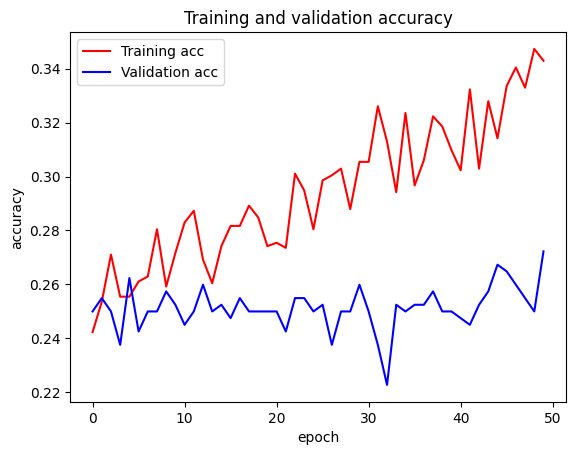

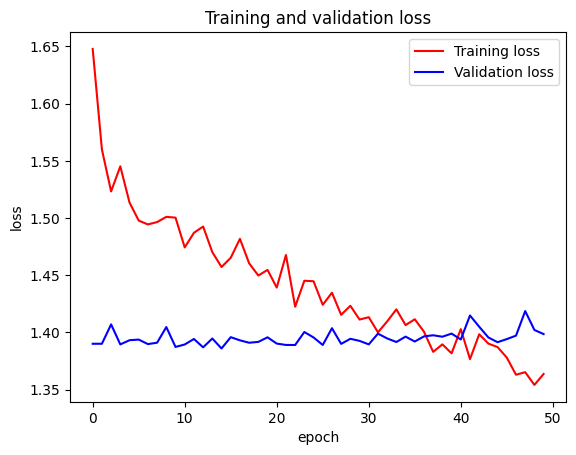

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()